In [1]:
import pandas as pd 
import torch
import numpy as np
from matplotlib import pyplot as plt
#from torchmetrics import JaccardIndex
import seaborn as sbn
from sklearn.metrics import roc_auc_score
import time
import torchvision
import torchvision.transforms as transforms
import matplotlib.cm as cm
import matplotlib as mpl


import sys 
sys.path.append('../src/')
from data_loading import load_tabular_data, preprocess_data, corrupt_label
from GenDataset import GenDataset
from DVGS import DVGS
from DVRL import DVRL
from utils import get_corruption_scores
from NN import NN
from CNN import CNN

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/dvgs/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
noise_idx = load_tabular_data('adult', {'train':1000, 'valid':400}, noise_rate=0.2) # saves to disk
x_train, y_train, x_valid, y_valid, x_test, y_test, col_names = preprocess_data('minmax', 'train.csv', 'valid.csv', 'test.csv')
train_dataset = GenDataset(x_train, y_train)
test_dataset = GenDataset(x_test, y_test)
valid_dataset = GenDataset(x_valid, y_valid)

do: 0.0
using device: cuda
epoch 99 || avg loss: 0.12 || grad time elapsed: 0.1 s0.0237s/batch)
time elapsed: 0.30 min
(1000,)
do: 0.08888888888888889
using device: cuda
epoch 99 || avg loss: 0.18 || grad time elapsed: 0.1 s0.0107s/batch)
time elapsed: 0.31 min
(1000,)
do: 0.17777777777777778
using device: cuda
epoch 99 || avg loss: 0.11 || grad time elapsed: 0.1 s0.0138s/batch)
time elapsed: 0.29 min
(1000,)
do: 0.26666666666666666
using device: cuda
epoch 99 || avg loss: 0.14 || grad time elapsed: 0.1 s0.0133s/batch)
time elapsed: 0.26 min
(1000,)
do: 0.35555555555555557
using device: cuda
epoch 99 || avg loss: 0.23 || grad time elapsed: 0.1 s0.0149s/batch)
time elapsed: 0.29 min
(1000,)
do: 0.4444444444444445
using device: cuda
epoch 99 || avg loss: 0.21 || grad time elapsed: 0.1 s0.0040s/batch)
time elapsed: 0.26 min
(1000,)
do: 0.5333333333333333
using device: cuda
epoch 99 || avg loss: 0.23 || grad time elapsed: 0.1 s0.0309s/batch)
time elapsed: 0.28 min
(1000,)
do: 0.62222222222

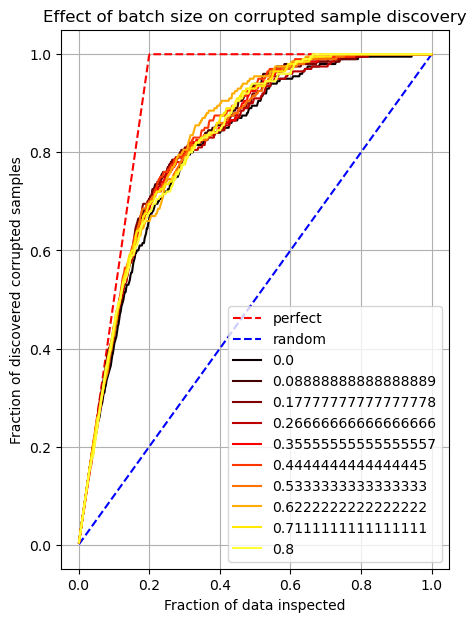

In [11]:
res = {'do': [], 'p_corr':[]} 
for do in np.linspace(0,0.8,10): 
    print('do:', do)
    model = NN(in_channels=108, out_channels=1, num_layers=1, hidden_channels=100, norm=False, dropout=do, bias=True, act=torch.nn.ReLU, out_fn=torch.nn.Sigmoid())
    dvgs = DVGS(train_dataset, valid_dataset, test_dataset, model)

    tic = time.time() 
    vals_dvgs, _ = dvgs.run(crit          = torch.nn.BCELoss(), 
                        similarity     = torch.nn.CosineSimilarity(dim=1), 
                        optim          = torch.optim.Adam, 
                        lr             = 1e-3, 
                        num_epochs     = 100, 
                        compute_every  = 1,
                        batch_size     = 400, 
                        num_workers    = 1, 
                        grad_params    = None, 
                        verbose        = True, 
                        use_cuda       = True)
    print()
    print(f'time elapsed: {(time.time() - tic)/60:.2f} min')

    pk, p_corr, p_perfect, p_random = get_corruption_scores(vals_dvgs.mean(axis=1), noise_idx, train_size=1000, noise_prop=0.2)
    res['do'].append(do)
    res['p_corr'].append(p_corr)

plt.figure(figsize=(5, 7))
plt.plot(pk, p_perfect, 'r--', label='perfect')
plt.plot(pk, p_random, 'b--', label='random')

norm = mpl.colors.Normalize(vmin=0., vmax=1.)
cmap = cm.hot
m = cm.ScalarMappable(norm=norm, cmap=cmap)

for ii,do in enumerate(res['do']):
    plt.plot(pk, res['p_corr'][ii], color=m.to_rgba(do), label=do, linestyle='solid')

plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.legend()
plt.grid(b=None)
plt.title('Effect of dropout on corrupted sample discovery')
plt.show()